# **Table of Contents**

1.   Table of contents

2.   Bibliography

3.   Contexte

4.   Librairies and dataframe's Import







# **Bibliography**

. Consignes : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/DAN-P10-cdc-detection-faux-billets.pdf

. Linear Regression : https://www.ibm.com/topics/linear-regression#:~:text=Linear%20regression%20analysis%20is%20used,is%20called%20the%20independent%20variable.

. Modelization : https://www.datacamp.com/blog/classification-machine-learning

. Cross validation : https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression

. K_means : https://towardsdatascience.com/unsupervised-learning-k-means-clustering-27416b95af27



# **Contexte**

The National Organization for the Fight against Counterfeiting, or ONCFM,
is a public organization whose objective is to set up
methods for identifying counterfeit euro banknotes. In the
framework of this fight, we wish to set up an algorithm which
is capable of automatically differentiating real notes from counterfeit notes.

**Goals**

When a ticket arrives, we have a machine that records everything
of its geometric characteristics. Through our years of struggle,
we observed dimensional differences between the real ones and the
fake tickets. These differences are difficult to notice with the naked eye, but
machine should be able to differentiate them without any problem.
Thus, it would be necessary to construct an algorithm which, from the characteristics
geometrical characteristics of a banknote, would be able to define whether the latter is a real
or a counterfeit note.

# **Librairies and dataframe's Import**

In [1]:
# Common libraries for ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno
import os
from os import listdir
import time
from pylab import figure, text, scatter, show
import re
import warnings
warnings.filterwarnings('ignore')
import time
import joblib



# Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Regressors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score



# Statistics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from statsmodels.api import qqplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(
'/content/drive/MyDrive/projet 10 data analyse/billets.csv', delimiter=';',
low_memory=False)

df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


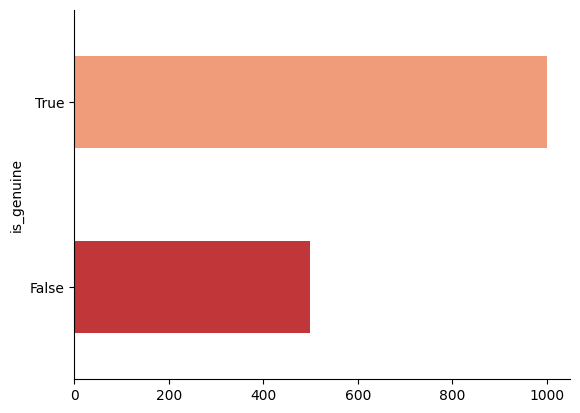

In [ ]:
# @title is_genuine

df.groupby('is_genuine').size().plot(kind='barh',
                                     color=sns.palettes.mpl_palette('RdGy'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Exploratory Data Analysis (EDA)**

In [ ]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [ ]:
def data_details(data):
    """
    This function allows, for a data set, to present and view:
      - the number of lines
      - the number of columns
      - the type of data in each column
      - the column name
      - the number of unique values in each column
      - A list containing the unique values of each column, if
        the length of the list does not exceed 100 values
      - the number of missing values in each column
      - the percentage of missing values in each column
      - the number of null values in each column (for numeric columns only)
      - the number of negative values in each column (for numeric columns only)
      - the number of duplicates in each column
    """

    print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
    columns = data.columns

    Nan_counts = data.isnull().sum().tolist()
    Neg_counts = []
    for column in columns:
        if data[column].dtype in ['int64', 'float64']:
            Neg_counts.append((data[column] < 0).sum())
        else:
            Neg_counts.append(np.nan)

    Nan_ratio = (data.isnull().sum() / len(data)).values
    Neg_ratio = []
    for column in columns:
        if data[column].dtype in ['int64', 'float64']:
            Neg_ratio.append(((data[column] < 0).sum() / len(data)) * 100)
        else:
            Neg_ratio.append(np.nan)

    Type = data.dtypes.tolist()
    count = [len(data[i].unique()) for i in columns]

    # Count number of duplicates in each column
    duplicates_count = [data[i].duplicated().sum() for i in columns]

    df = pd.DataFrame({'Columns name': columns,
                       'Type': Type,
                       '# unique values': count,
                       '# Nan values': Nan_counts,
                       '# Neg values': Neg_counts,
                       '% Nan values': Nan_ratio * 100,
                       '% Neg values': Neg_ratio,
                       '# duplicates': duplicates_count
                       })
    return df


def data_summary(data):
  """
 This function provides a summary of the dataset:
    - the number of lines
    - the number of columns
    - the number of datatype of the columns
    - the percentage of missing values ​​in the dataset
  """

  total_per_missing_data = (data.isnull().sum()/len(data)).values.\
  sum()/data.shape[1]*100

  df= pd.DataFrame({'# Columns':data.shape[1],
                    '# Rows':data.shape[0],
                    '# Col Types':data.dtypes.nunique(),
                    'Col Types and #':[[(index,count) for count, index in
                                        zip(data.dtypes.value_counts(),
                                            data.dtypes.value_counts().index)
                                        ]],
                    'Nan total %':total_per_missing_data
                    })
  return df

# Generate colors from the RdGy palette
colors = sns.color_palette("RdGy", 4)

def data_plot(x):
    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(x=np.squeeze(x),
                                       labels=['% missing value',
                                               '% non-missing value'],
                                       autopct='%1.1f%%',
                                       explode=(0, 0.1),
                                       shadow=True,
                                       colors = colors,
                                       startangle=0)

    plt.title('% total Nan in the dataset', pad=20)

    # Incliner le texte "missing value"
    for text in texts:
        if text.get_text() == '% missing value':
            text.set_rotation(45)

    plt.legend(title="Legend",
               loc="center left",
               bbox_to_anchor=(1.05, 0.5),
               borderaxespad=0.)
    plt.show()


def data_presentation(data):
  """
  This function provides a representation of the dataset
  """
  print()
  print()
  print('Display the first 5 rows of the dataset')
  print()
  print()
  display(data.head())

  print()
  print()
  print('Display the last 5 rows of the dataset')
  print()
  print()
  display(data.tail())

  print()
  print()
  print('Display a summary of the dataset')
  print()
  print()
  df_summary = data_summary(data)
  display(df_summary)


  print()
  print()
  print('Display a summary of the columns of the dataset')
  print()
  print()
  df_details = data_details(data)
  display(df_details)

  print()
  print()
  print('Display a summary of the types of columns in the dataset')
  print()
  print()
  display(df_details.Type.value_counts().to_frame())

  print()
  print()
  print('Percentage of missing values ​​in the dataset')
  print()
  print()
  data_plot([df_summary.iloc[:,-1],
             100 - df_summary.iloc[:,-1]]
            )

  return None


def shape_details(df):
  print(f"Number of lines : {df.shape[0]}")
  print(f"Number of columns : {df.shape[1]}")
  return None

def data_checking(df):
  """
  Get information related to the data frame data as:
  - Head
  - Tail
  - Missing values percentage and numbers
  - Number of unique values
  - Number of different columns type

  """

  shape_details(df)
  print(100*'__')
  print(100*'__')
  data_presentation(df)
  print(100*'__')
  print(100*'__')
  msno.bar(df)


Number of lines : 1500
Number of columns : 7
________________________________________________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________________________________________________


Display the first 5 rows of the dataset




,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54




Display the last 5 rows of the dataset




,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07




Display a summary of the dataset




,# Columns,# Rows,# Col Types,Col Types and #,Nan total %
0,7,1500,2,"[(float64, 6), (bool, 1)]",0.352381




Display a summary of the columns of the dataset


Dataset contains 1500 rows and 7 columns


,Columns name,Type,# unique values,# Nan values,# Neg values,% Nan values,% Neg values,# duplicates
0,is_genuine,bool,2,0,NaN,0.000000,NaN,1498
1,diagonal,float64,159,0,0.0,0.000000,0.0,1341
2,height_left,float64,155,0,0.0,0.000000,0.0,1345
3,height_right,float64,170,0,0.0,0.000000,0.0,1330
4,margin_low,float64,286,37,0.0,2.466667,0.0,1214
5,margin_up,float64,123,0,0.0,0.000000,0.0,1377
6,length,float64,336,0,0.0,0.000000,0.0,1164




Display a summary of the types of columns in the dataset




,count
Type,
float64,6
bool,1




Percentage of missing values ​​in the dataset




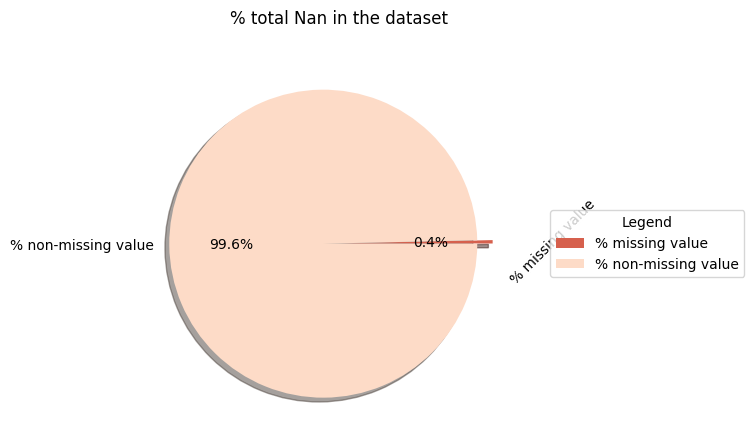

________________________________________________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________________________________________________


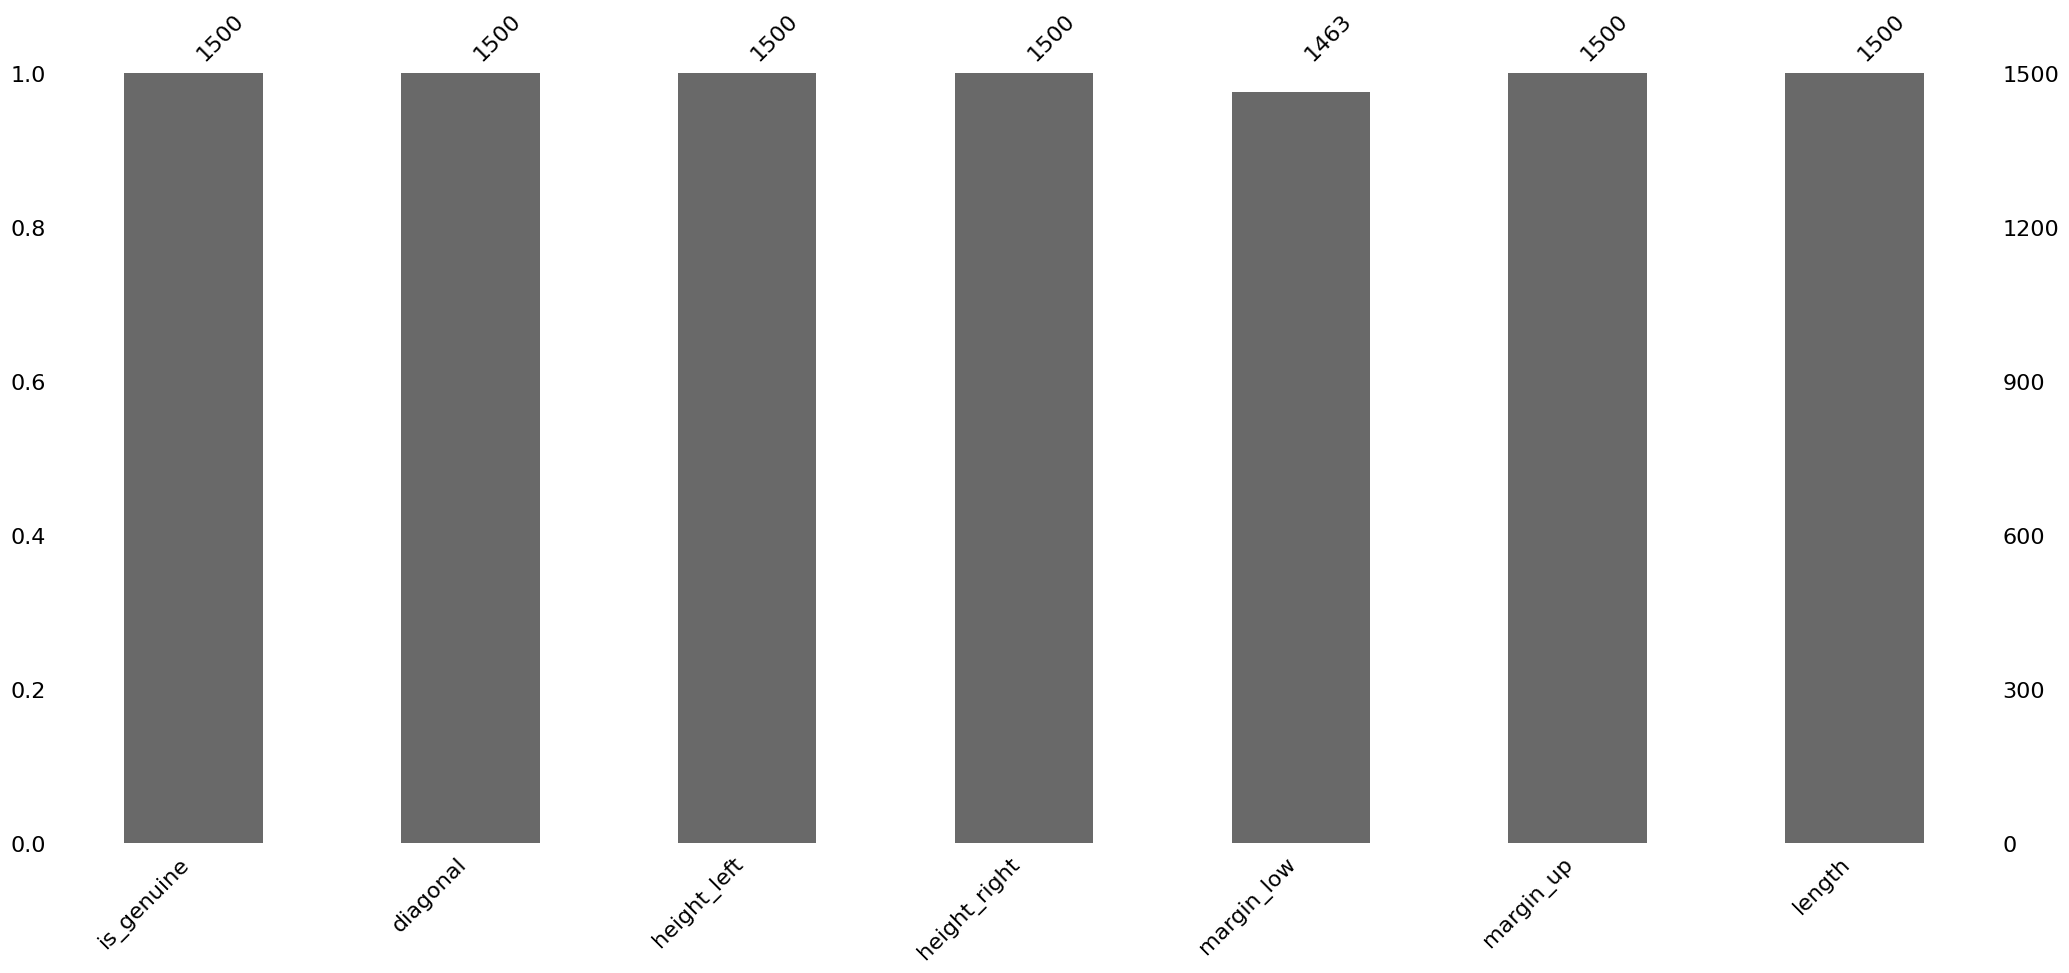

In [ ]:
data_checking(df)

In [ ]:
# df with missing values
df.loc[df['margin_low'].isna()]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


We notice that:

Our initial dataset includes 1500 banknotes with their dimensional characteristics as well as their state (True/False).

The dimensions of the dataset are 1500 individuals on 7 variables.

Missing data margin_low (37 data), of these 37 missing, 29 are true (2.9% of all real notes) and 8 are false (1.6% of all fake notes).

All variables are of type float (which is normal because they are dimensions in mm) with the exception of is_genuine which is a bool, represents the category of a ticket: true/false.

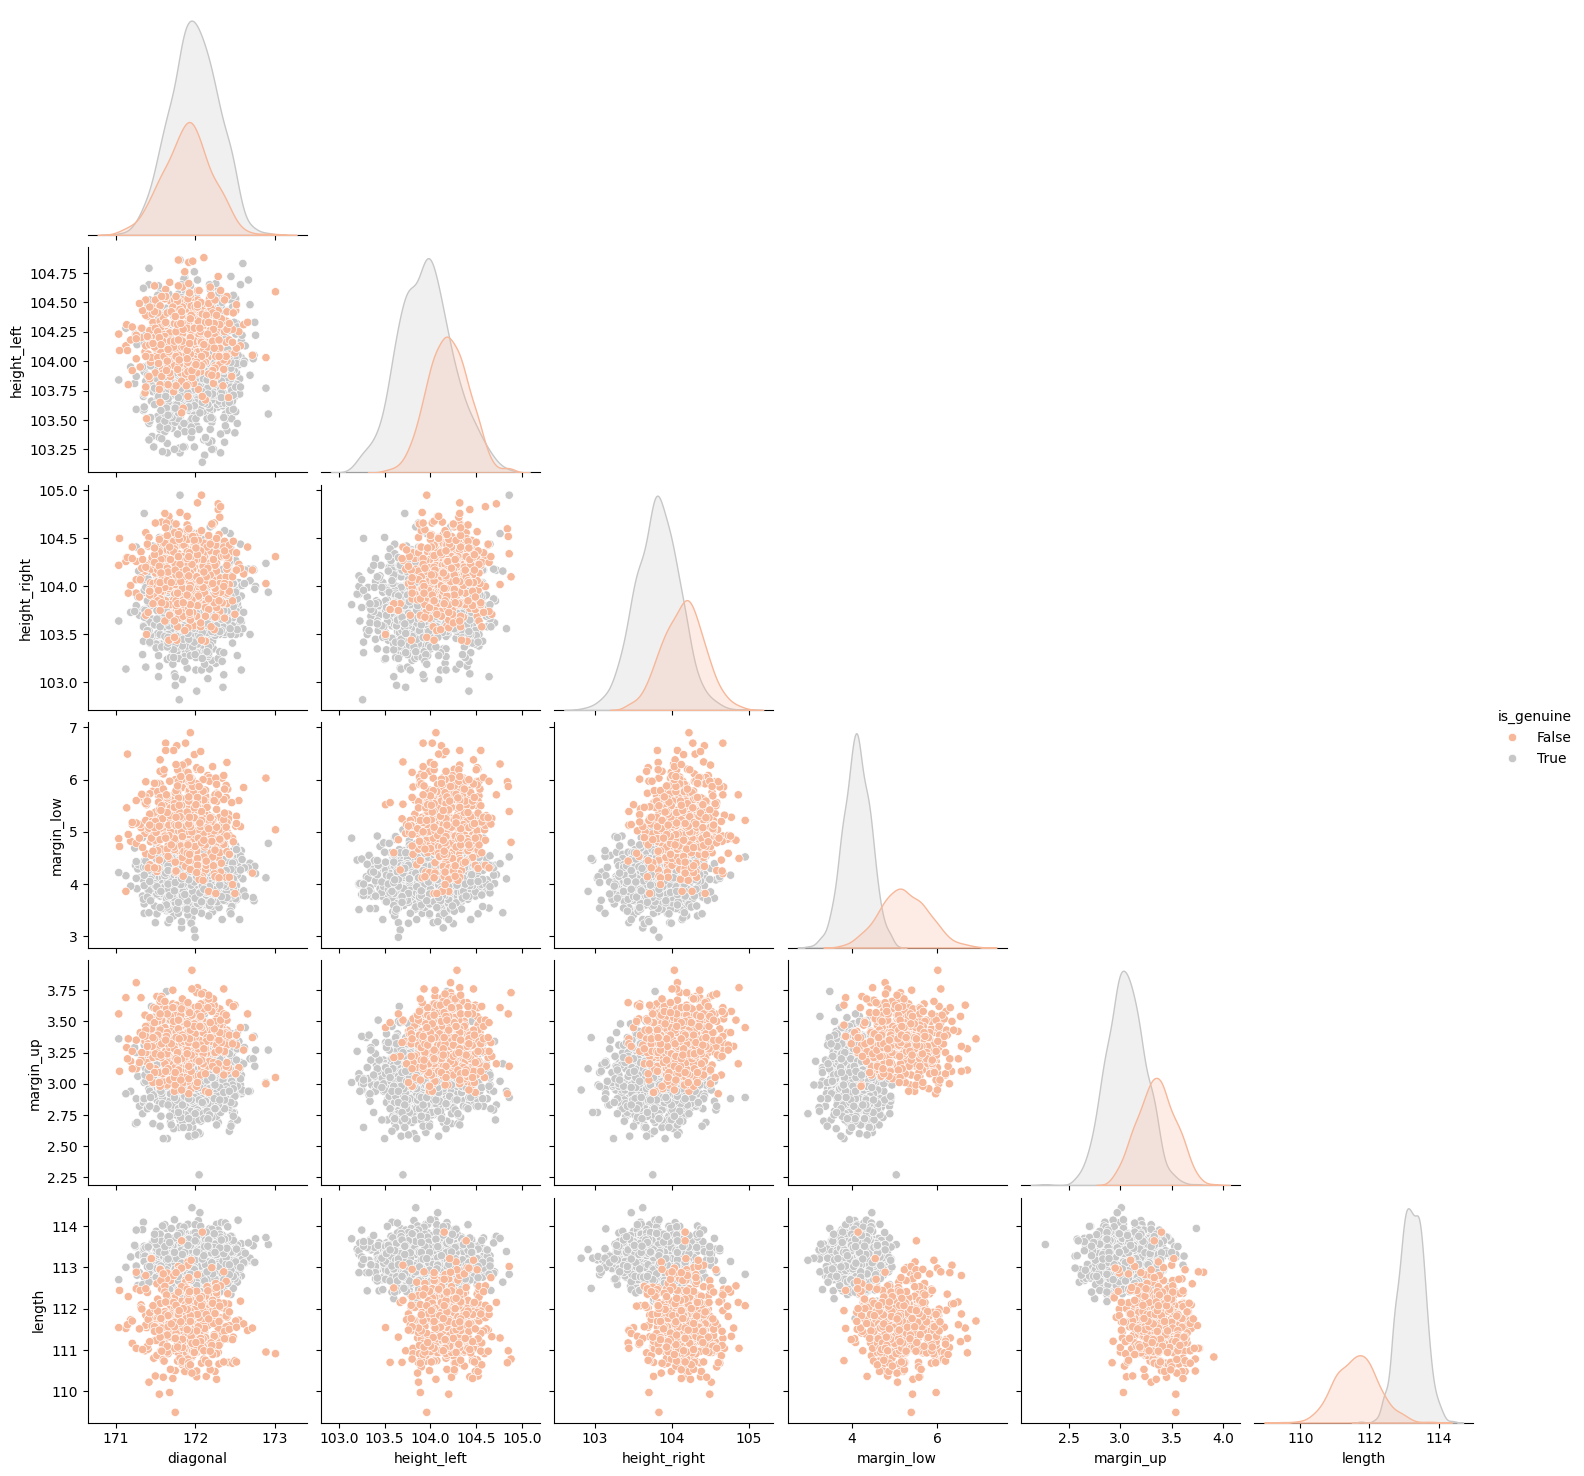

In [ ]:
# Pairplot
sns.pairplot(df, hue = 'is_genuine',
             palette = 'RdGy', corner = True)

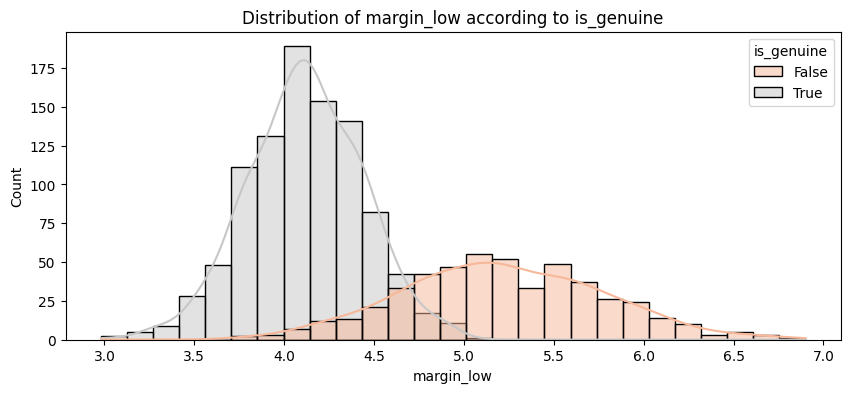

In [ ]:
# We look more precisely at margin_low depending on the type of ticket
# Creation of the figure and graph
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='margin_low', fill=True, hue='is_genuine',
             palette='RdGy', kde=True)

# Added title
plt.title('Distribution of margin_low according to is_genuine')

# Graph display
plt.show()

Looking at the distribution of margin_low between real and fake banknotes we notice a strong demarcation, this is also noticeable with a boxplot.

This therefore means that margin_low could be useful data in order to detect fake goods with ML.

The pairplot also gives us some additional information about the difference between ticket type, such as length.

Processing of these values:


We can consider several solutions:

   * Imputation by mean or median
   * Using an ML model: multiple linear regression
   * Remove rows with missing
  
We chose to use the 2nd method.

**Fill in missing values ​​using linear regression**

We will use Linear regression to fill in missing values. But before this we should make sure that our data meets linear-regression assumptions.

1. Linearity

We should check if there is a linear relationship between the independent variables (features) and the dependent variable (target). We can use scatter plots or correlation matrices.

2. Independence of Errors

We should ensure that the residuals (errors) are independents. This can be checked using the Durbin-Watson test.

3. Homoscedasticity

We should verify that the residuals have constant variance at all levels of the independent variables. This can be checked using residual plots.

4. Normality of Errors

We should check if the residuals are normally distributed. This can be done using Q-Q plots or histograms.


Checking assumptions for filling missing values in column: margin_low
Checking Linearity...


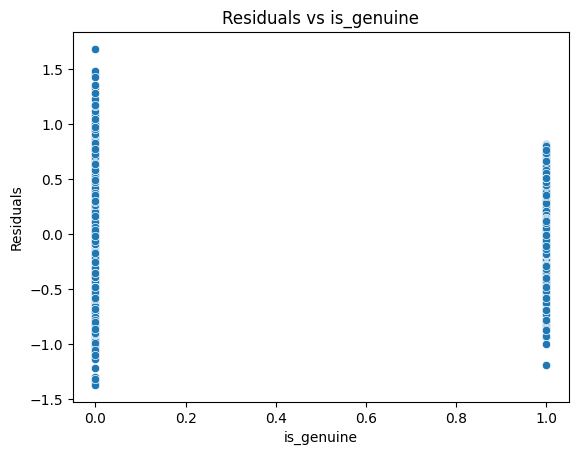

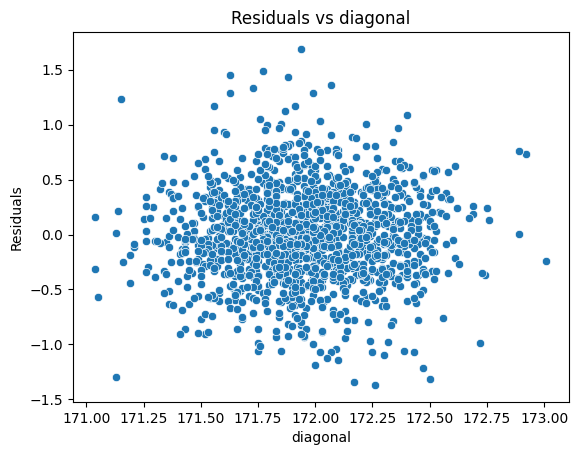

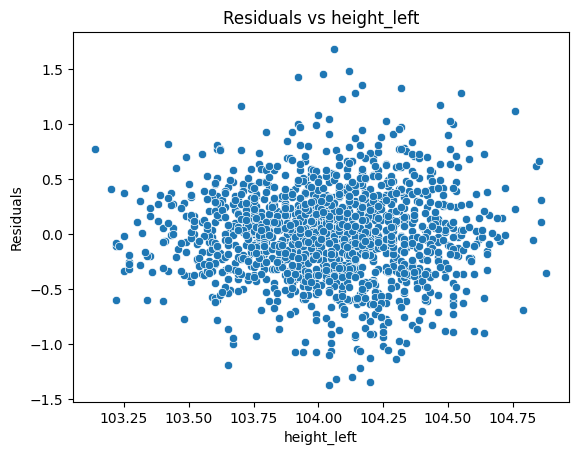

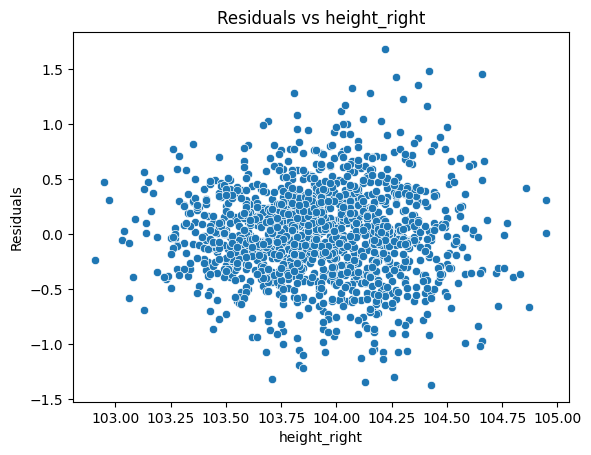

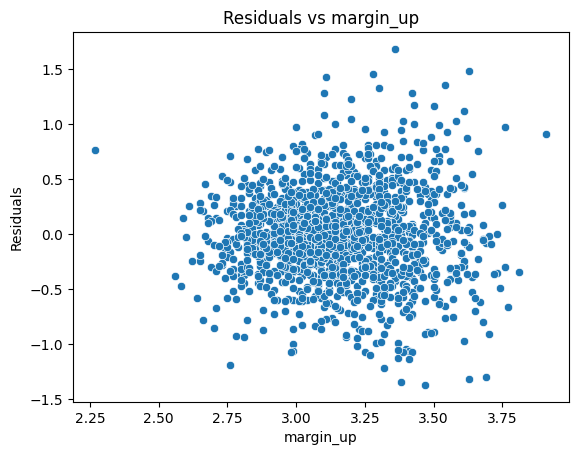

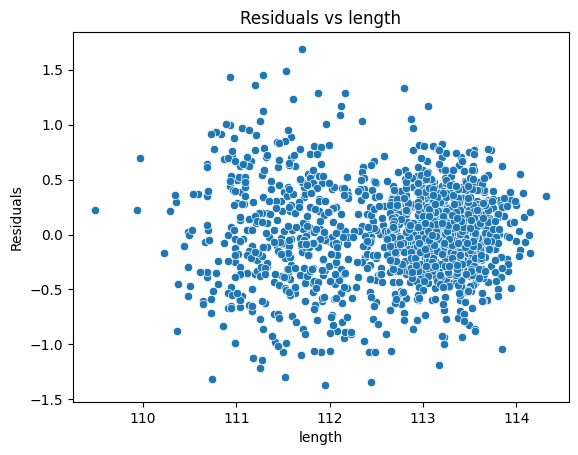

Checking Independence of Errors...
Durbin-Watson statistic: 2.0384864739178643
No significant autocorrelation detected.
Checking Homoscedasticity...


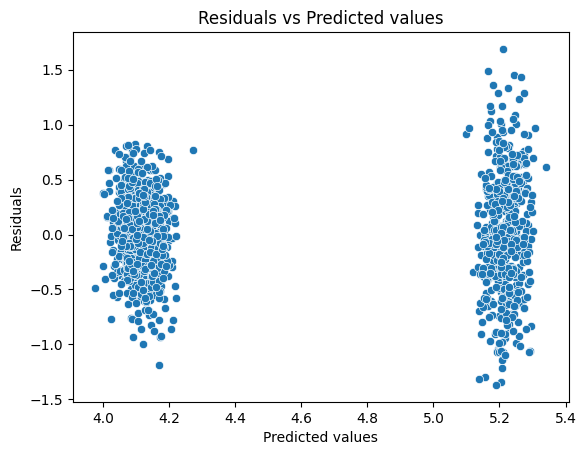

Checking Normality of Errors...


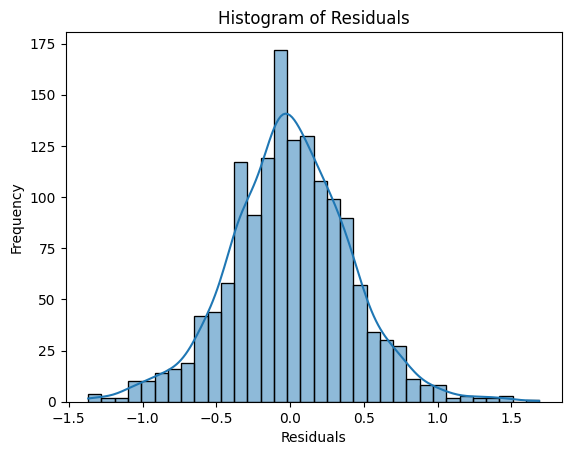

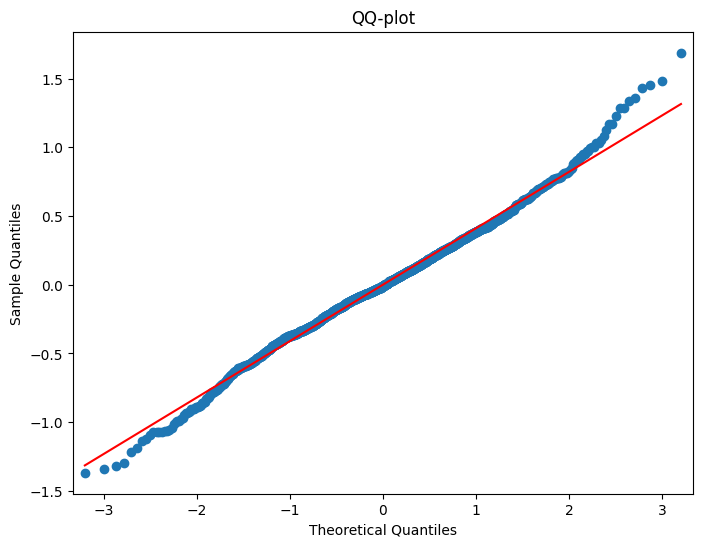

Shapiro-Wilk test statistic: 0.9936957822741039, p-value: 7.060681650657966e-06
Residuals are not normally distributed (reject H0).


In [ ]:
# Function to check assumptions of linear regression
def check_regression_assumptions(df, target_column):
    # Drop rows where the target column is NaN for initial analysis
    df_no_nan = df.dropna(subset=[target_column])

    # Split data
    X = df_no_nan.drop(columns=[target_column])
    y = df_no_nan[target_column]

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 1. Linearity
    print("Checking Linearity...")
    for col in X.columns:
        plt.figure()
        sns.scatterplot(x=df_no_nan[col], y=residuals)
        plt.title(f'Residuals vs {col}')
        plt.xlabel(col)
        plt.ylabel('Residuals')
        plt.show()

    # 2. Independence of Errors
    print("Checking Independence of Errors...")
    dw_stat = durbin_watson(residuals)
    print(f'Durbin-Watson statistic: {dw_stat}')
    if dw_stat < 1.5:
        print("There may be positive autocorrelation.")
    elif dw_stat > 2.5:
        print("There may be negative autocorrelation.")
    else:
        print("No significant autocorrelation detected.")

    # 3. Homoscedasticity
    print("Checking Homoscedasticity...")
    plt.figure()
    sns.scatterplot(x=y_pred, y=residuals)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted values')
    plt.show()

    # 4. Normality of Errors
    print("Checking Normality of Errors...")
    plt.figure()
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()


    # QQ-plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title('QQ-plot')
    plt.show()

    # Shapiro-Wilk test for normality
    stat, p = shapiro(residuals)
    print(f'Shapiro-Wilk test statistic: {stat}, p-value: {p}')
    if p > 0.05:
        print("Residuals are normally distributed (fail to reject H0).")
    else:
        print("Residuals are not normally distributed (reject H0).")

# Check assumptions for each column with missing values
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(f'\nChecking assumptions for filling missing values in column: {column}')
        check_regression_assumptions(df, column)

1. Checking linearity
Goal: Ensure that the relationship between each independent variable and the dependent variable is linear.

Interpretation: Graphs: Each graph shows the residuals as a function of each predictor. The points should be randomly distributed around the horizontal line (residual = 0).

Result obtained: No clear pattern (such as a curve or U-shaped pattern), which would indicate a linear relationship.

2. Error independence
Goal: Check that the residuals (errors) are independent of each other using the Durbin-Watson test.

Interpretation: Durbin-Watson (DW) statistic:

< 1.5: Indicates positive autocorrelation
2.5: Indicates negative autocorrelation.

Between 1.5 and 2.5: Indicates a significant absence of autocorrelation.

Result obtained: A value between 1.5 and 2.5. So the residues are independent of each other.

3. Homoscedasticity
Goal: Verify that the error variance is constant across all predictive values.

Interpretation:

Graphic: Residuals should be evenly distributed around the horizontal line, with no particular pattern.

Result obtained: A distribution of residues without obvious structure (like a funnel pattern).

4. Normality of errors
Goal: Verify that the errors follow a normal distribution.

How to: Use a histogram of residuals and a Q-Q plot, as well as the Shapiro-Wilk test.

Interpretation:

Histogram: The distribution of residuals should resemble a bell curve (normal distribution).

Q-Q plot: The points lie approximately on the reference line.

Shapiro-Wilk test:

p-value > 0.05: We do not reject the null hypothesis, indicating that the residuals are normally distributed.

p-value ≤ 0.05: We reject the null hypothesis, indicating that the residuals are not normally distributed.

Result obtained: A p-value less than 0.05.

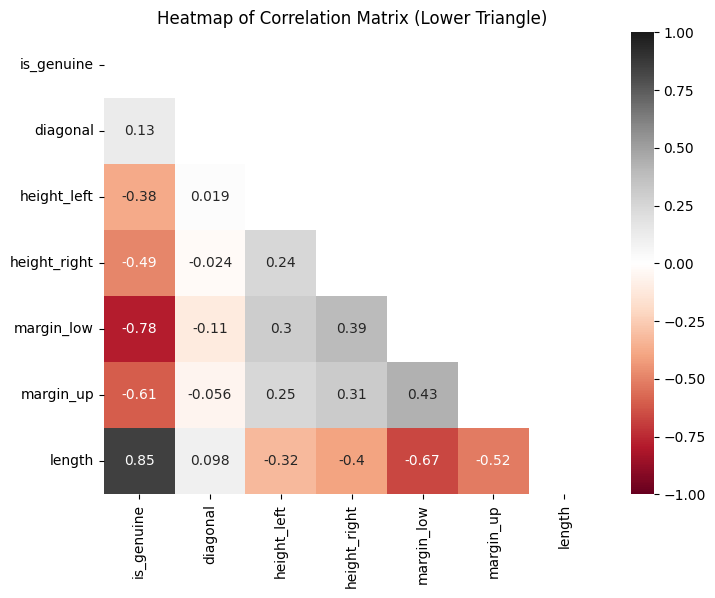

In [ ]:
# We make a heatmap on our complete df in order to have a first view of the correlation with margin_low
# Calculation of the correlation matrix
corr_matrix = df.corr()

# Creating the mask for the upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Trace the heatmap with the mask
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdGy', vmin=-1, vmax=1, mask=mask)
plt.title('Heatmap of Correlation Matrix (Lower Triangle)')
plt.show()

We notice that margin_low strongly depends on margin_up in positive and is_genuine in negative, the length could also be used.

These three variables could be used to predict margin_low.

To confirm this, we will do a backward selection of margin_low depending on the other variables

In [4]:
# Set backward selection function
def backward_selection(data, response):
    initial_features = data.columns.tolist()
    initial_features.remove(response)
    best_features = initial_features.copy()

    step = 1
    while len(best_features) > 0:
        formula = "{} ~ {}".format(response, ' + '.join(best_features))
        model = smf.ols(formula, data=data).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclure l'intercept

        print(f"Step {step}:")
        print("Formula: ", formula)
        print("P-values:\n", pvalues)

        worst_feature = pvalues.idxmax()
        if pvalues[worst_feature] > 0.05:
            print(f"Removing {worst_feature} with p-value\
             {pvalues[worst_feature]}\n")
            best_features.remove(worst_feature)
        else:
            print("No features to remove. Stopping.\n")
            break

        step += 1

    formula = "{} ~ {}".format(response, ' + '.join(best_features))
    final_model = smf.ols(formula, data=data).fit()
    return final_model

# Apply selection backwards to find the explanatory variables of 'margin_low'
final_model = backward_selection(df, 'margin_low')
print(final_model.summary())

Step 1:
Formula:  margin_low ~ is_genuine + diagonal + height_left + height_right + margin_up + length
P-values:
 is_genuine[T.True]    2.579893e-100
diagonal               7.158169e-01
height_left            4.676056e-01
height_right           4.835844e-01
margin_up              3.029751e-04
length                 8.684507e-01
dtype: float64
Removing length with p-value             0.8684506945587165

Step 2:
Formula:  margin_low ~ is_genuine + diagonal + height_left + height_right + margin_up
P-values:
 is_genuine[T.True]    9.138608e-196
diagonal               7.190804e-01
height_left            4.682035e-01
height_right           4.856683e-01
margin_up              3.024414e-04
dtype: float64
Removing diagonal with p-value             0.7190803565120467

Step 3:
Formula:  margin_low ~ is_genuine + height_left + height_right + margin_up
P-values:
 is_genuine[T.True]    1.369001e-199
height_left            4.827402e-01
height_right           4.959953e-01
margin_up              2.8851

Now that we have our explanatory variables, we can perform a multifactor linear regression on them.


The variables to use found by backward selection are: margin_up and is_genuine, to predict our missing margin_low values.

In [5]:
# Select predictor columns
predictor_columns = ['is_genuine', 'margin_up']
target_column = 'margin_low'

# Check if there are missing values ​​in the target_column column
if df[target_column].isna().sum() > 0:
    # Create DataFrames for training and testing
    train_df = df.dropna(subset=[target_column])
    test_df = df[df[target_column].isna()]

    # Separate features (X) and target (y) for training
    X_train = train_df[predictor_columns]
    y_train = train_df[target_column]

    # Prepare test data
    X_test = test_df[predictor_columns]

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict missing values ​​and fill them in the original DataFrame
    df.loc[df[target_column].isna(), target_column] = model.predict(X_test)

# Check that all missing values ​​are filled
print(df.isna().sum())


is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


To evaluate our regression we will calculate the R2.

R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.

An R2 of 1 indicates that the model perfectly predicts the target variable, while an R2 of 0 indicates that the model does no better than a horizontal line (mean of the target variable).

In [6]:
# Calculate predictions on the training data to evaluate the model
y_train_pred = model.predict(X_train)

# Calculate R^2 on the training data
r2 = r2_score(y_train, y_train_pred)
print(f'R^2 on the training data: {r2}')

R^2 on the training data: 0.6165658589903711


An R2 of 0.6166 indicates that our model has captured a good portion of the variance.

**Data visualization**

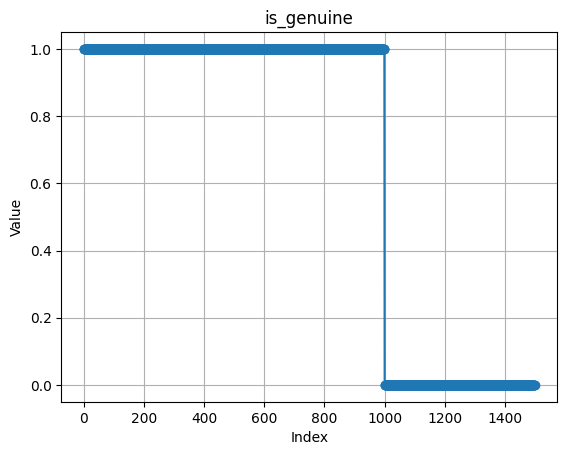

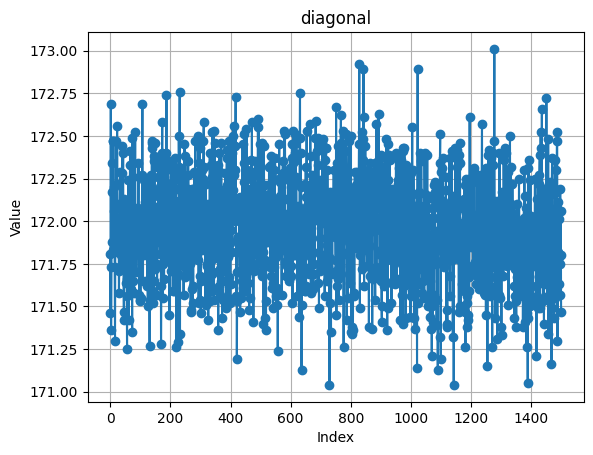

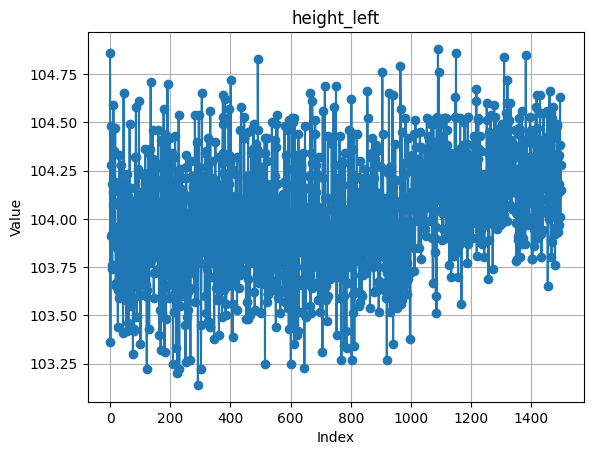

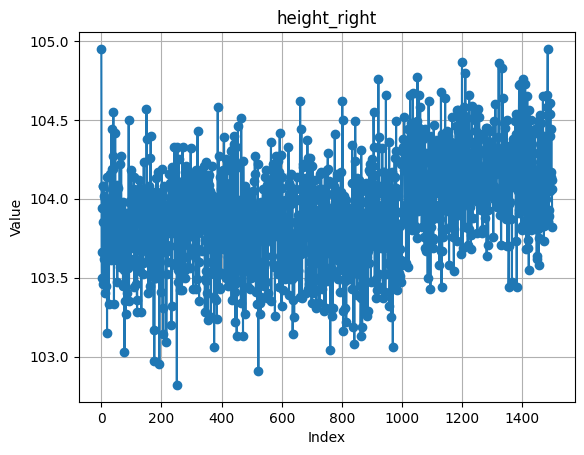

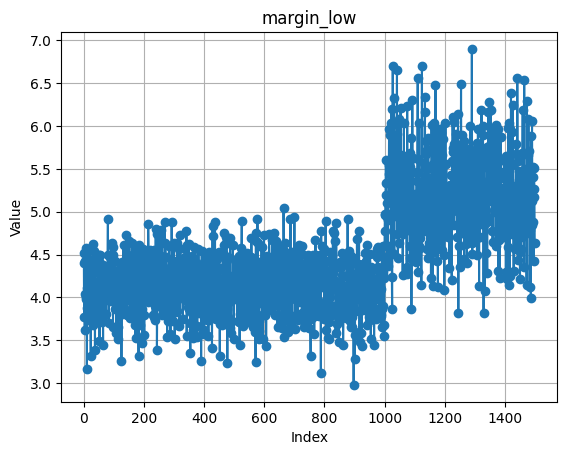

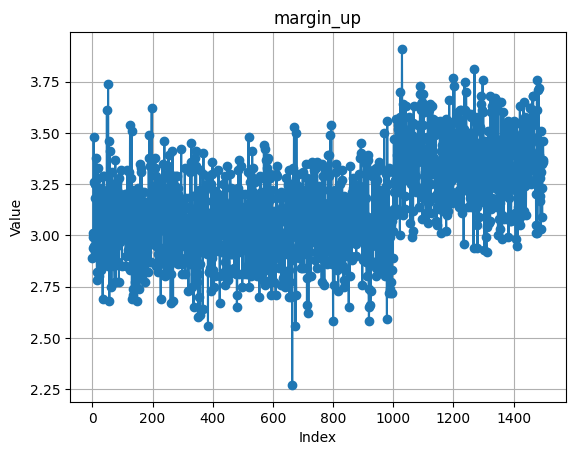

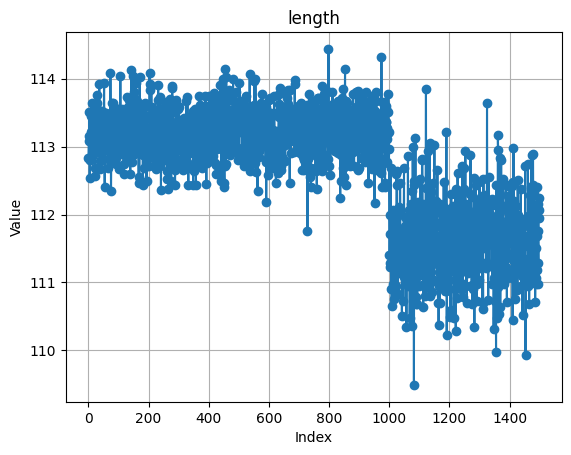

In [ ]:
def plot_variable(df, variable):
    """
    Cette fonction génère un graphique pour une variable donnée.
    """
    plt.figure()
    plt.plot(df[variable], 'o-')
    plt.title(variable)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Liste des variables à tracer (excluant is_genuine)
variables = df.columns

# Tracer chaque variable
for variable in variables:
    plot_variable(df, variable)


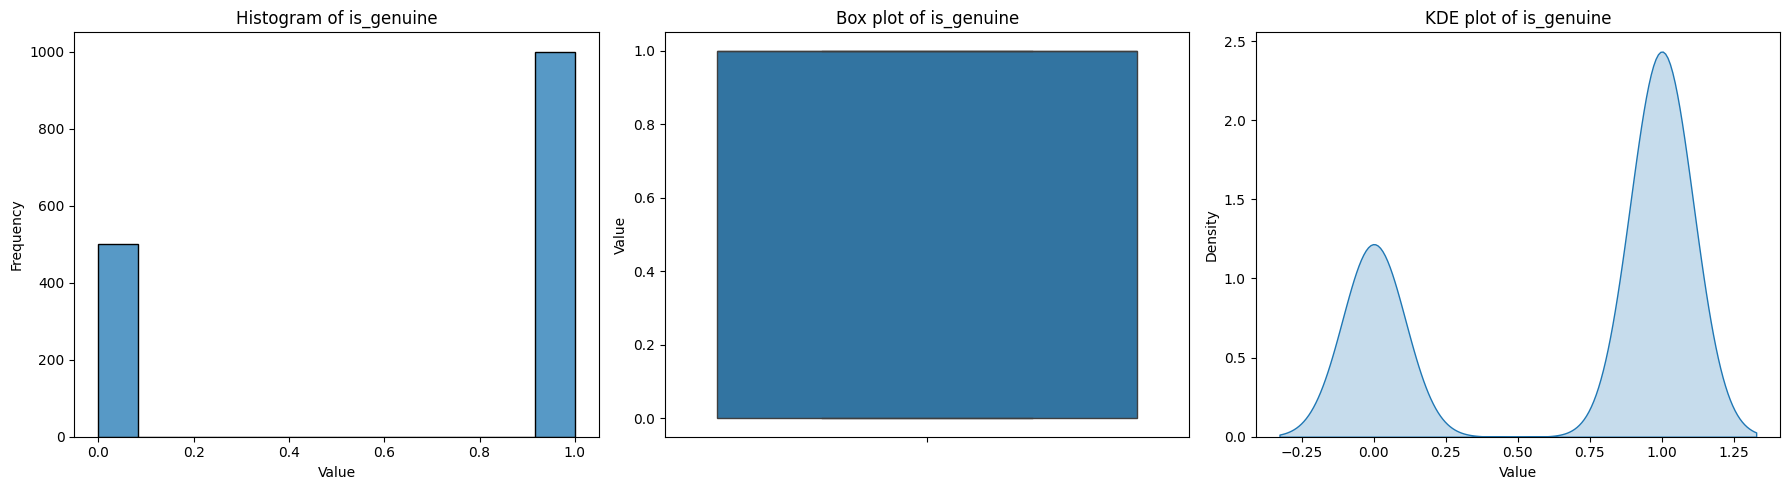

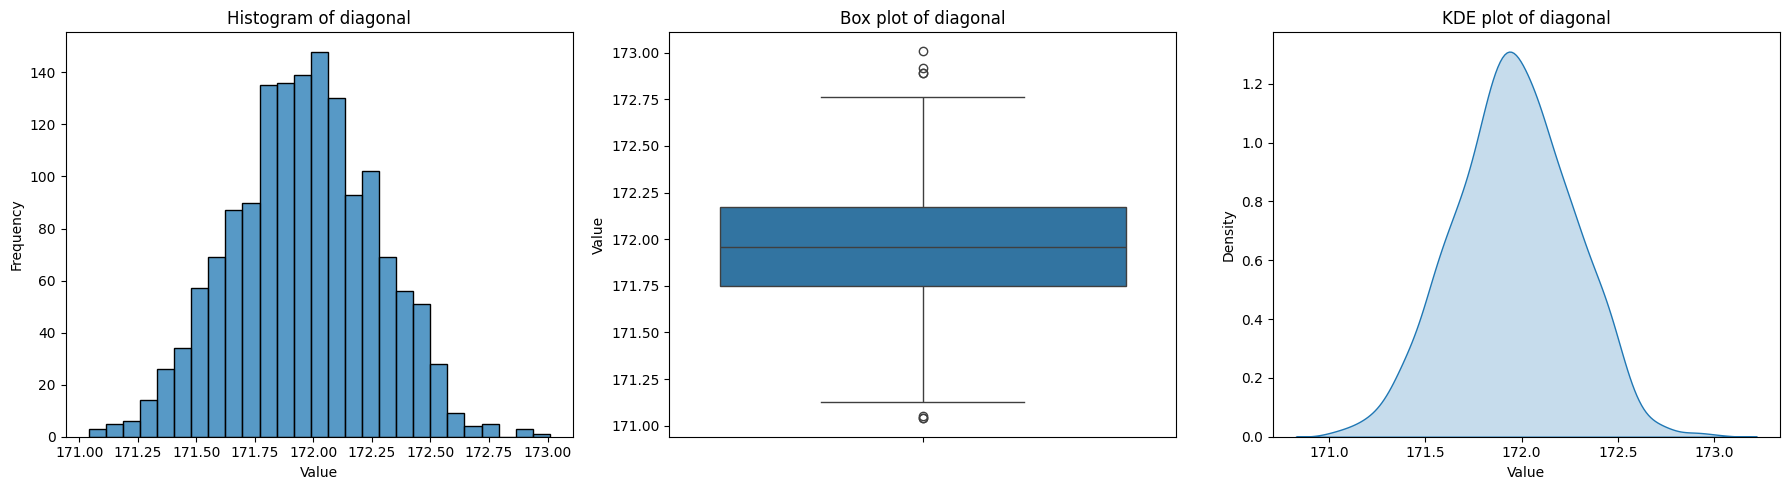

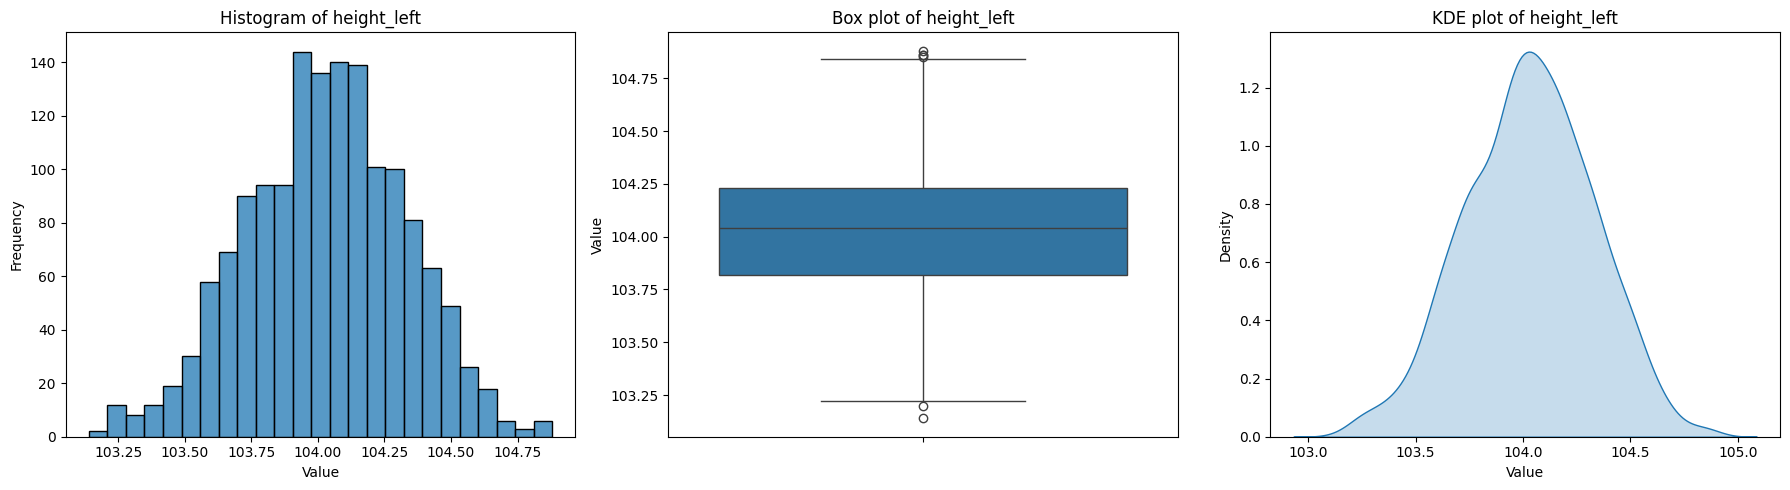

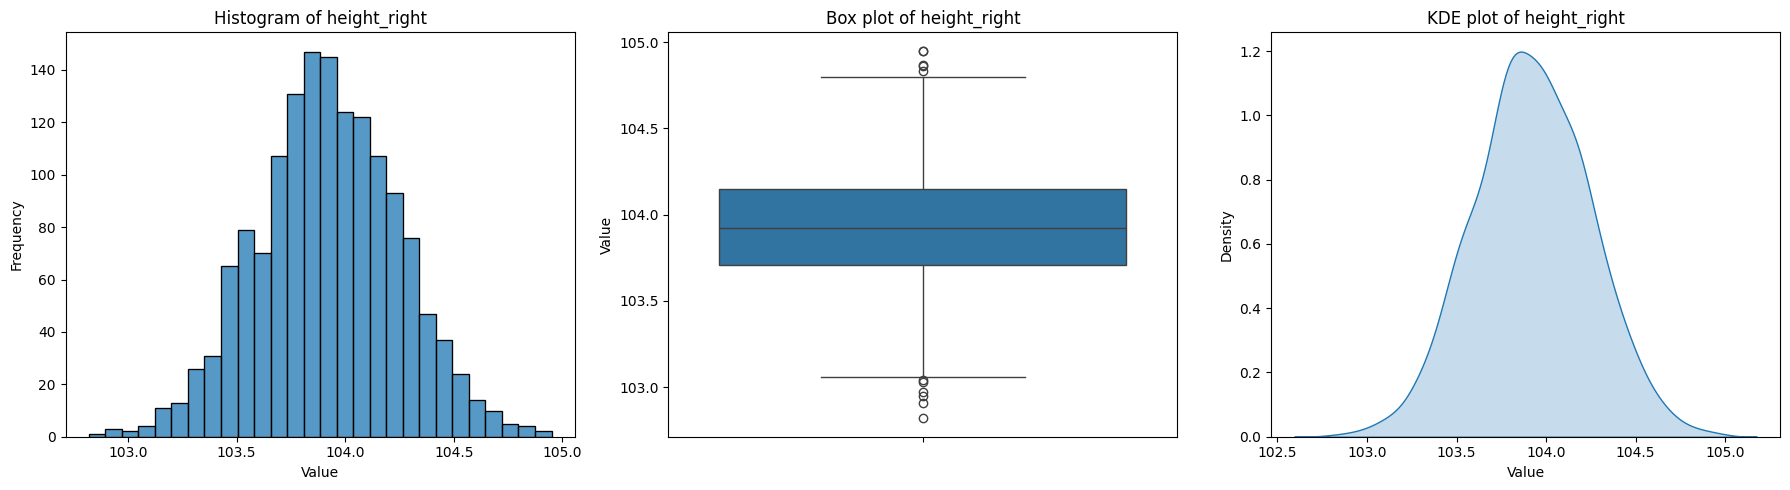

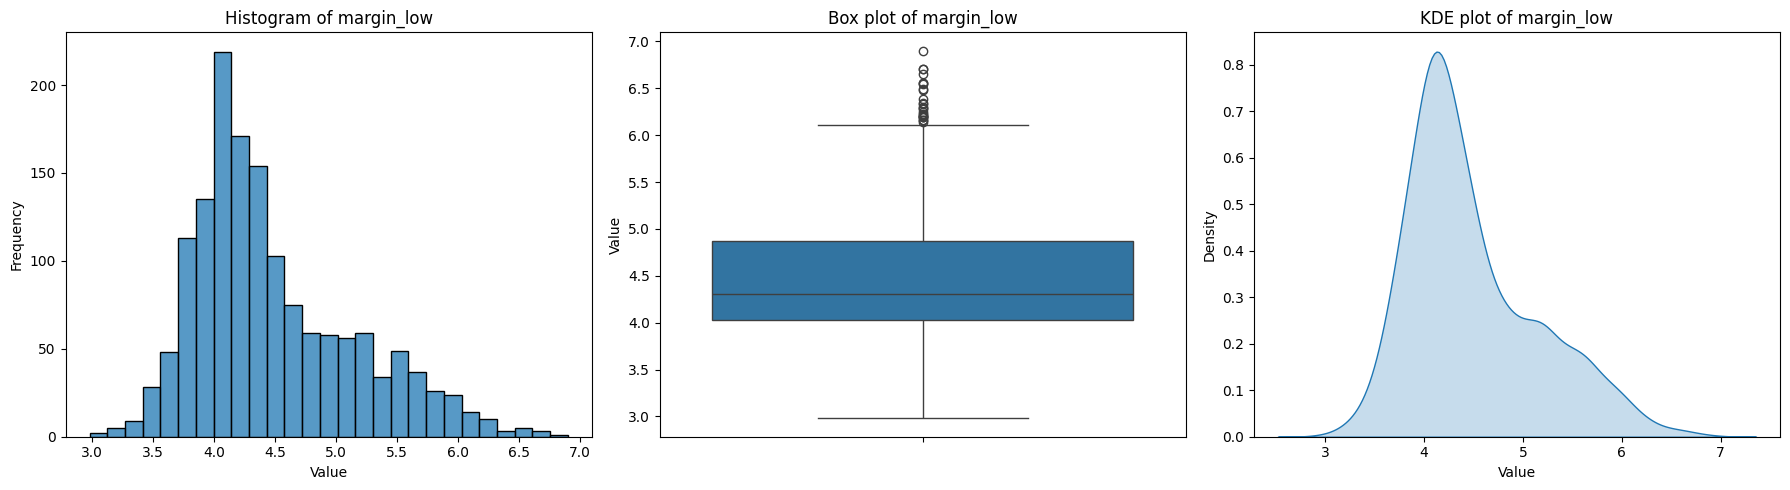

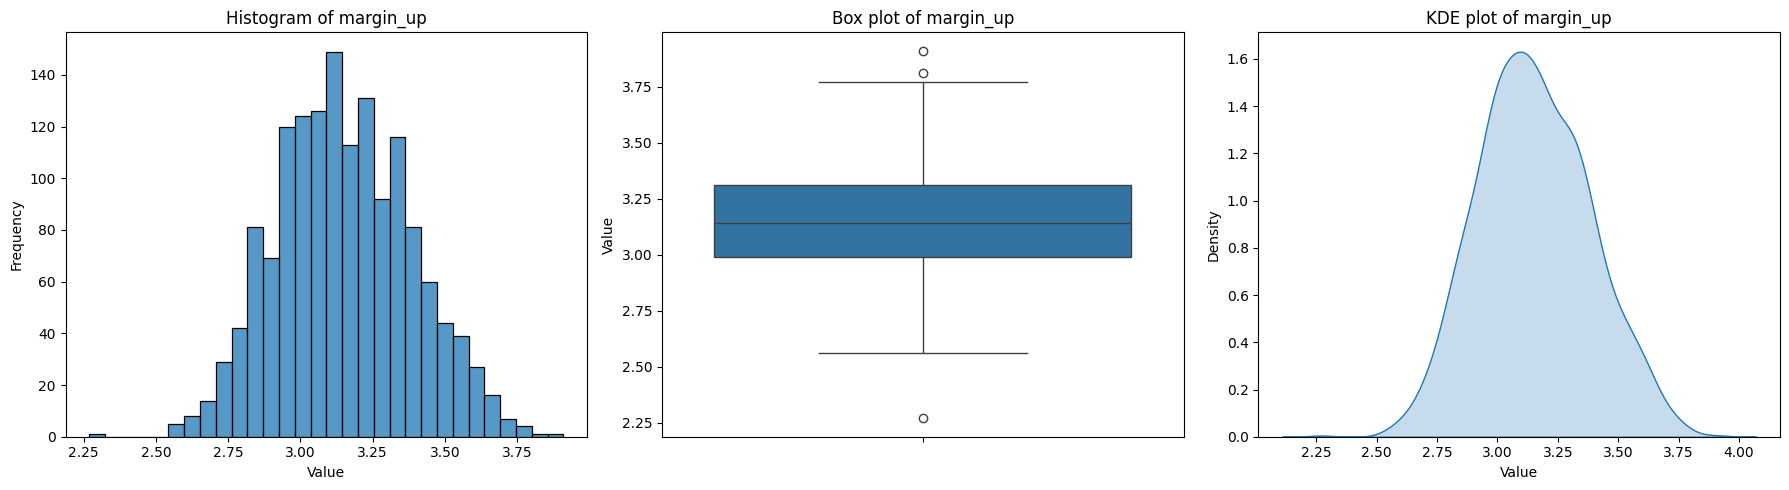

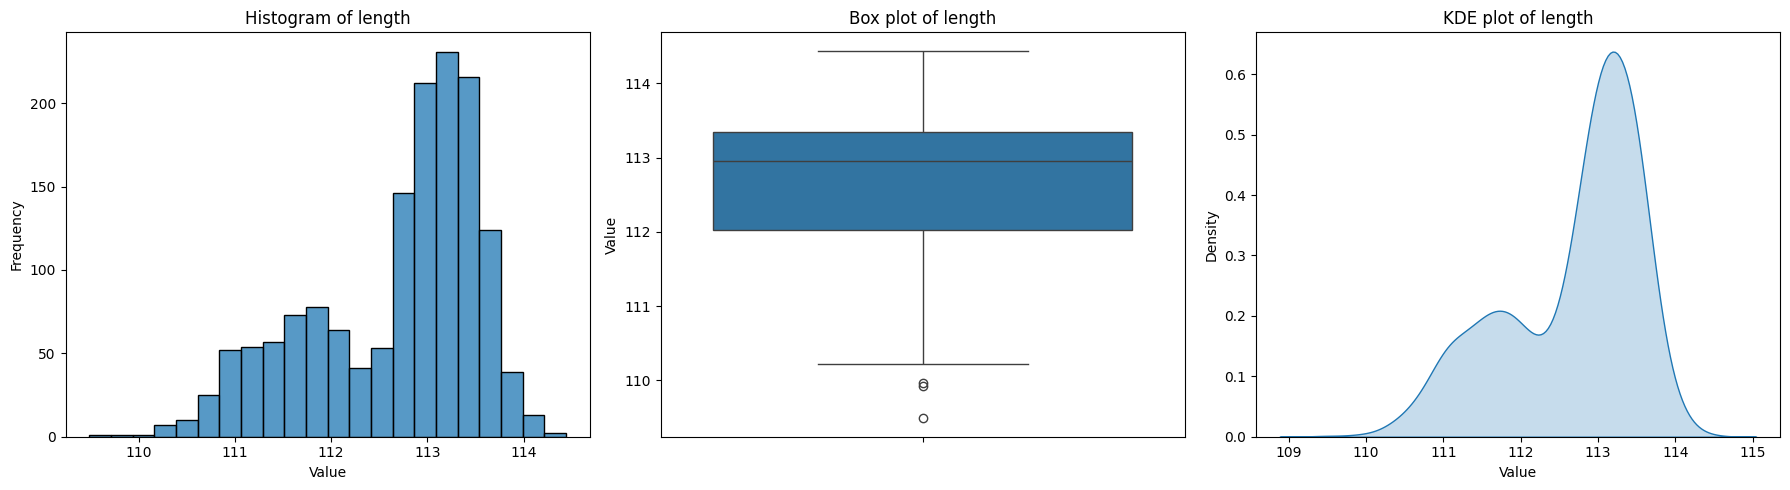

In [ ]:
def plot_variable_distribution(df, variable):
    """
    This function generates a histogram, a box plot and a KDE plot for a given
    variable, and displays them on the same line.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram
    sns.histplot(df[variable], kde=False, ax=axes[0])
    axes[0].set_title(f'Histogram of {variable}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(y=df[variable], ax=axes[1])
    axes[1].set_title(f'Box plot of {variable}')
    axes[1].set_ylabel('Value')

    # KDE plot
    sns.kdeplot(df[variable], shade=True, ax=axes[2])
    axes[2].set_title(f'KDE plot of {variable}')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

# List of variables to trace (excluding is_genuine)
variables = df.columns

# Plot each variable with the three types of graphs
for variable in variables:
    plot_variable_distribution(df, variable)


In [ ]:
df[(df['diagonal'] > 172.75) | (df['diagonal'] < 171.1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
231,True,172.76,104.22,104.00,4.20,3.27,113.69
729,True,171.04,103.84,103.64,4.22,3.36,112.70
828,True,172.92,103.55,103.94,4.78,3.27,113.55
842,True,172.89,103.77,104.24,4.12,3.01,113.72
1022,False,172.89,104.03,104.03,6.03,3.00,110.95
1142,False,171.04,104.23,104.22,4.87,3.56,111.54
1277,False,173.01,104.59,104.31,5.04,3.05,110.91
1388,False,171.05,104.09,104.50,4.72,3.10,112.44


We notice some outliers in our variables which are not "extreme", this may be due to the wear of the notes, slight manufacturing differences...

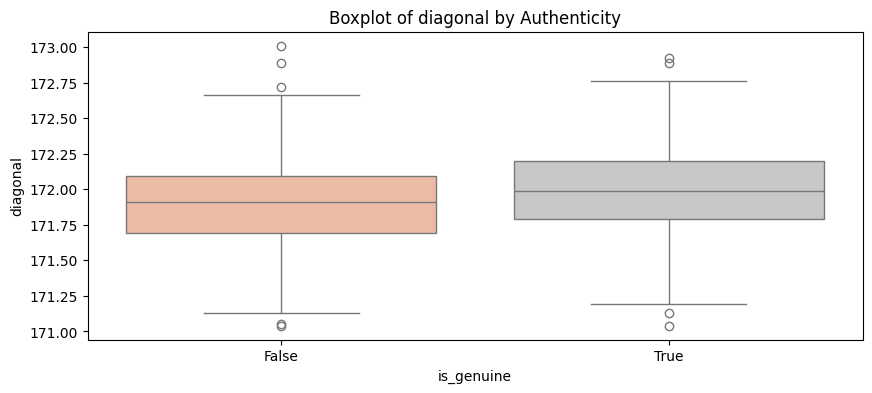

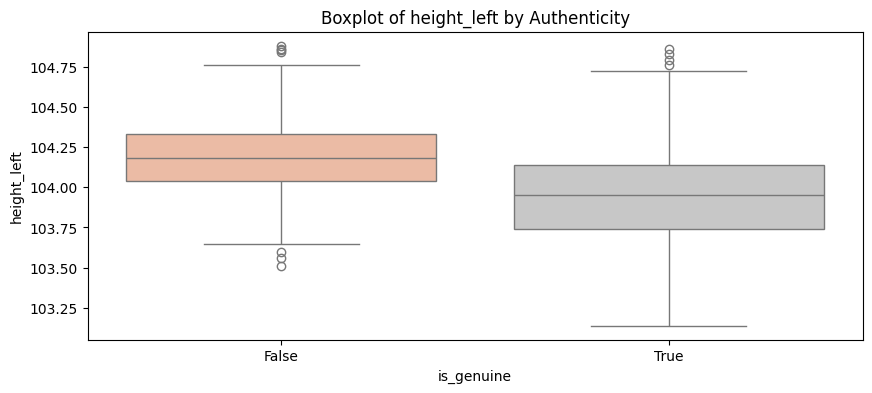

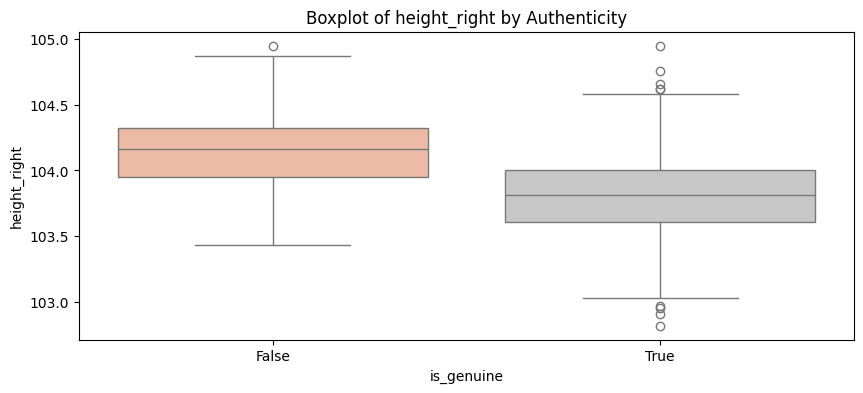

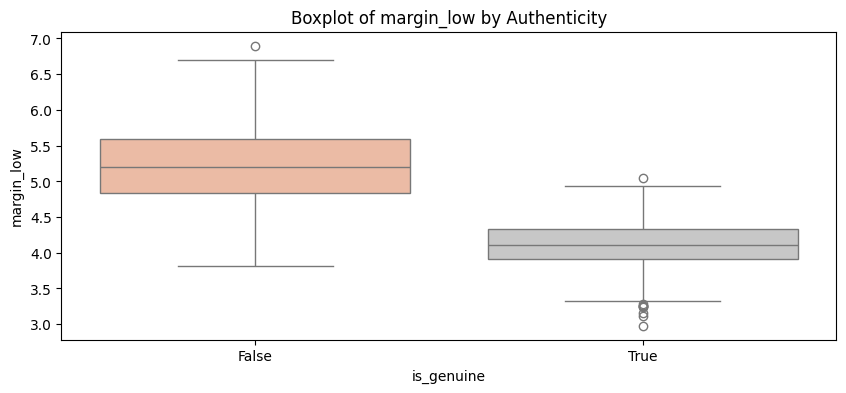

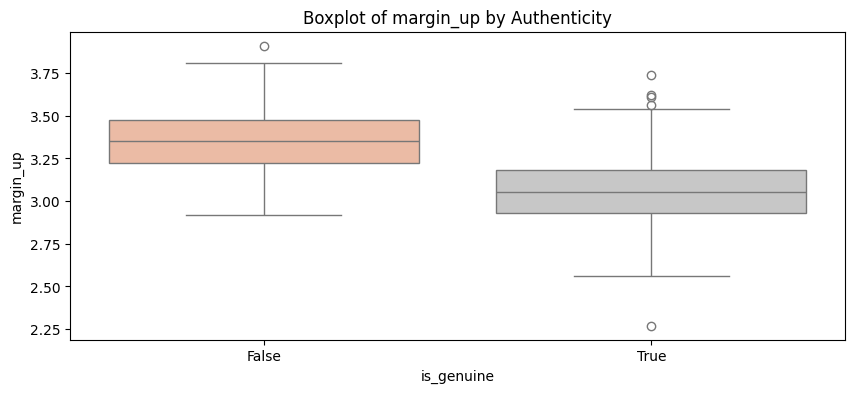

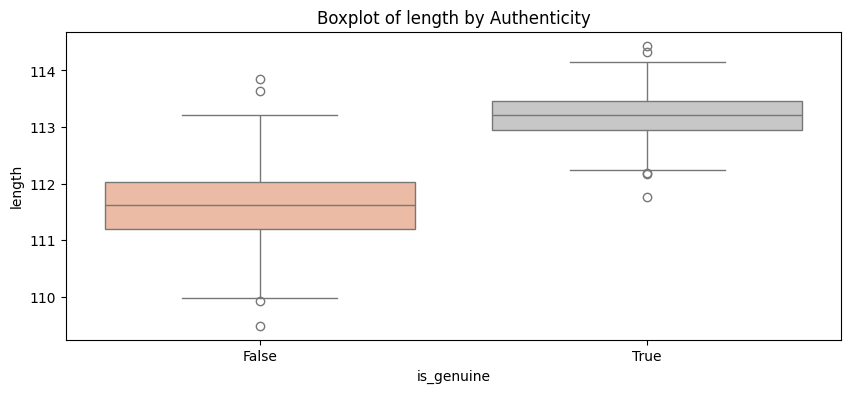

In [ ]:
# Filter numeric columns
digital_vars = df.select_dtypes(include=['float64', 'int64']).columns

# Creating boxplots for each numeric variable against is_genuine
for var in digital_vars:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='is_genuine', y=var, data=df, palette='RdGy')
    plt.title(f'Boxplot of {var} by Authenticity')
    plt.show()

We notice that the fake notes are those which have high 'margin_up', 'margin_low', 'height_left' and 'height right' values ​​and low 'lenght' values.

# **Unsupervised classification: Kmeans**

Now we are going to use Kmeans to see if it can predict real and fake notes for us.

K-means clustering is an unsupervised algorithm that groups unlabelled data into different clusters.


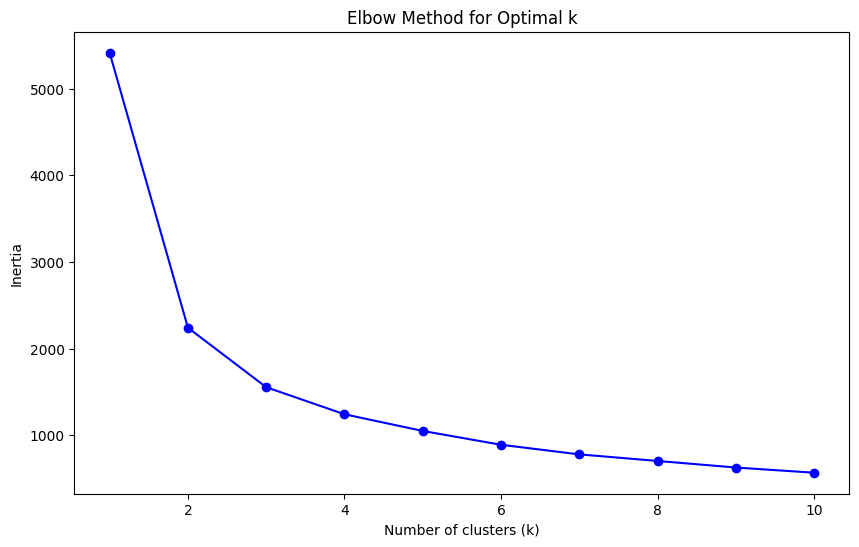

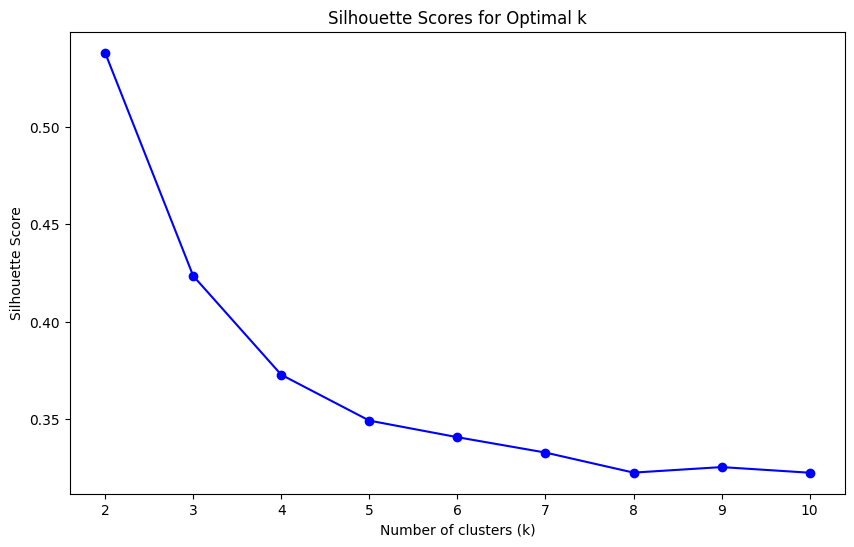

In [ ]:
X = df.drop(columns=['is_genuine'])
y = df['is_genuine']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Carry out a PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal k')
plt.show()


We notice that the "elbow" in the inertia graph and the best silhouette score indicate that the ideal number of clusters as expected is equal to 2.

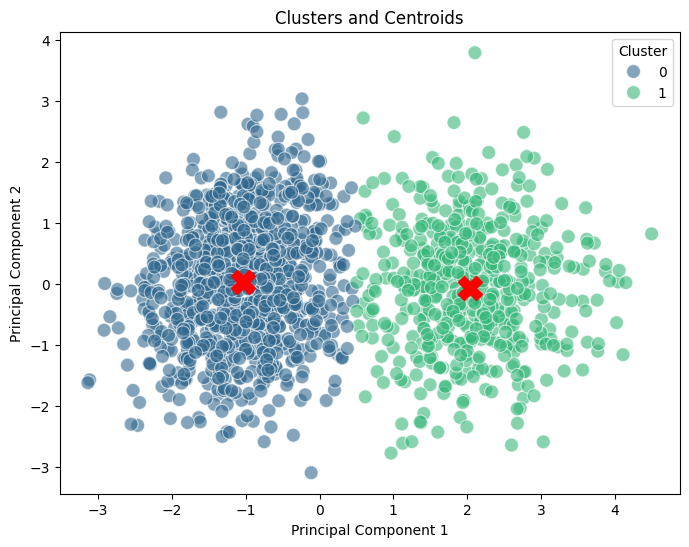

Centroids:
[[-1.03565989  0.03120754]
 [ 2.04055761 -0.06148812]]


In [ ]:
# The optimal number of clusters found is 2
optimal_k = 2

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add the clusters to the original DataFrame
df['Cluster'] = clusters

# Visualize the clusters and centroids
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'],
                palette='viridis', s=100, alpha=0.6)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X')
plt.title('Clusters and Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Print the centroids
print("Centroids:")
print(centroids)


Cluster separation:

The 2 clusters appear as distinct groups of points, each with a different color. There are no overlaps.

Centroids:

The red "X" shaped marks represent the centroids.
The position of the centroids is at the center of each group of points. This indicates that each cluster is well represented by its centroid.

Cluster 0 is denser than cluster 1.

Clearly, Kmeans was able to distinguish the two types of tickets.

In [ ]:
# Calculate the distances from each point to the centroids
distances = kmeans.transform(X_pca)

# Obtain the distances to the assigned centroid
assigned_cluster_distances = np.min(distances, axis=1)

# Add these distances to the DataFrame
df['Distance_to_Centroid'] = assigned_cluster_distances

# Optional: Add cluster information
df['Cluster'] = kmeans.labels_

# Show the first rows of the DataFrame to check
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster,Distance_to_Centroid
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1,0.899309
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0,2.444754
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0,2.588972
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0,1.879884
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0,1.328001


In [ ]:
# Show the distribution of labels for each cluster
print(df.groupby(['Cluster', 'is_genuine']).size())

Cluster  is_genuine
0        False          12
         True          983
1        False         488
         True           17
dtype: int64


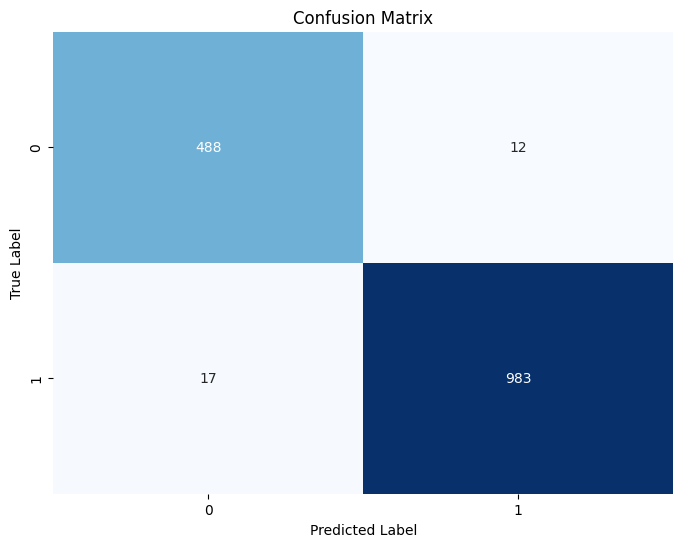

Accuracy: 0.9807
Precision: 0.9879
Recall: 0.9830
F1 Score: 0.9855


In [ ]:
# Invert the clusters to align them correctly
df['Cluster'] = 1 - df['Cluster']

# Create the confusion matrix
conf_matrix = confusion_matrix(df['is_genuine'], df['Cluster'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculation of metrics
accuracy = accuracy_score(df['is_genuine'], df['Cluster'])
precision = precision_score(df['is_genuine'], df['Cluster'])
recall = recall_score(df['is_genuine'], df['Cluster'])
f1 = f1_score(df['is_genuine'], df['Cluster'])

# Show results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

These results show that the model has very high performance.

High Accuracy (0.9807): The model is generally good at making correct predictions.

High precision (0.9879): The model makes very few errors when predicting a post as true.

High recall (0.9830): The model is very good at identifying most real notes.

F1 High Score (0.9855): The model maintains an excellent balance between precision and recall, meaning it is reliable for this classification task.

# **Supervised classification**

The supervised classification is a machine learning method where the model tries to predict the correct label of a given input data. In classification, the model is fully trained using the training data, and then it is evaluated on test data before being used to perform prediction on new unseen data.

We will use some models like:

Logistic Regression.

Support Vector Machine.

Decision Trees.

Artificial Neural Networks.

In [7]:
# Separation of data into training and testing set
X = df.drop(columns=['is_genuine'])
y = df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name, results):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Initialize results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [],
           'F1 Score': []}

In [10]:
# Models to evaluate
models = {
 "Random Forest": RandomForestClassifier(random_state=42),
 "Logistic Regression": LogisticRegression(random_state=42),
 "SVM": SVC(random_state=42),
 "Neural Network": MLPClassifier(random_state=42, max_iter=300)
}

In [11]:
# Train and evaluate each model
for model_name, model in models.items():
    train_and_evaluate_model(model, model_name, results)

--- Random Forest ---
Accuracy: 0.9933333333333333
Precision: 0.9895833333333334
Recall: 1.0
F1 Score: 0.9947643979057591
--- Logistic Regression ---
Accuracy: 0.9933333333333333
Precision: 0.9895833333333334
Recall: 1.0
F1 Score: 0.9947643979057591
--- SVM ---
Accuracy: 0.9966666666666667
Precision: 0.9947643979057592
Recall: 1.0
F1 Score: 0.9973753280839895
--- Neural Network ---
Accuracy: 0.99
Precision: 0.9895287958115183
Recall: 0.9947368421052631
F1 Score: 0.9921259842519685


In [12]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results in table form
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.993333,0.989583,1.000000,0.994764
1,Logistic Regression,0.993333,0.989583,1.000000,0.994764
2,SVM,0.996667,0.994764,1.000000,0.997375
3,Neural Network,0.990000,0.989529,0.994737,0.992126


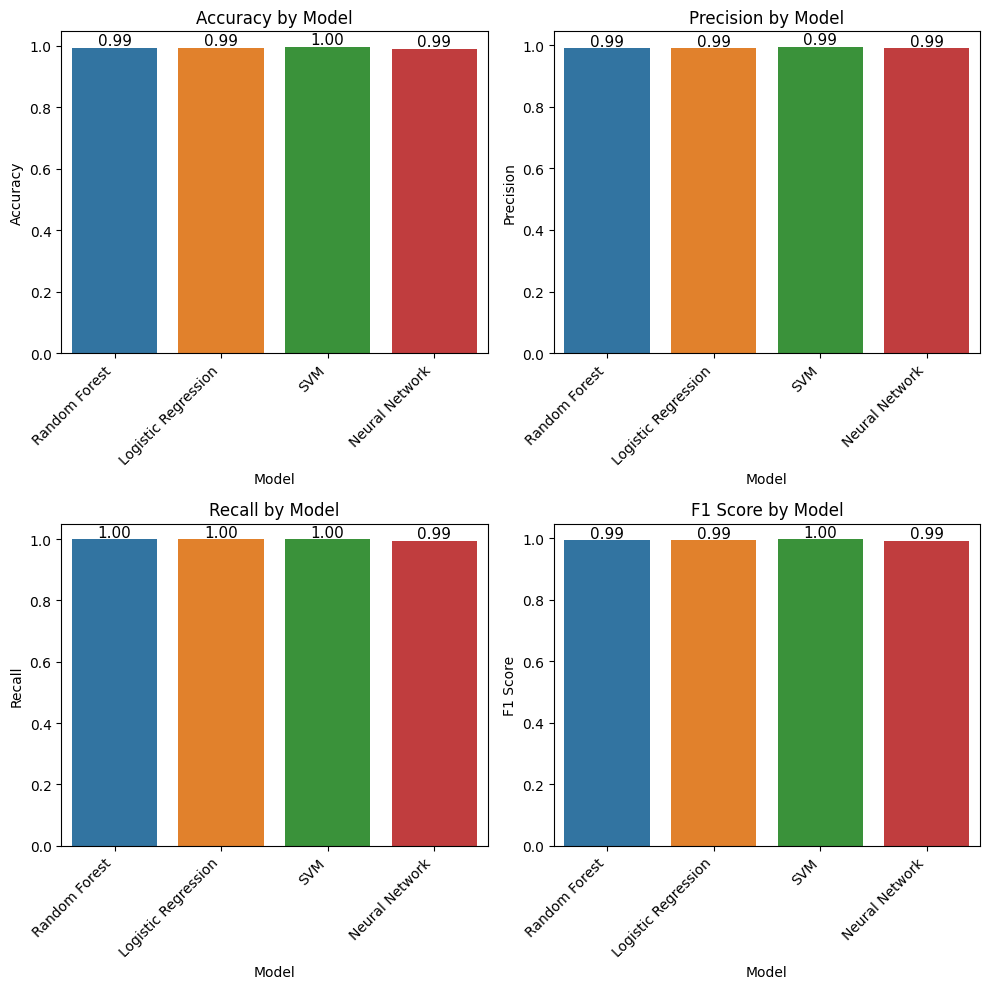

In [13]:
# Visualize results as graphs
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

colors = sns.color_palette("tab10")

for idx, metric in enumerate(metrics):
 sns.barplot(x='Model', y=metric, data=results_df, ax=axes[idx], palette=colors)
 axes[idx].set_title(f'{metric} by Model')
 axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
 for p in axes[idx].patches:
   height = p.get_height()
   axes[idx].annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center', fontsize=11, color='black',
                      xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

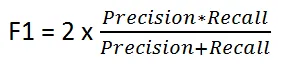

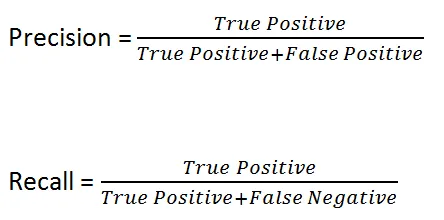![image.png]()

We can clearly see that the values ​​obtained for the different metrics in the 4 models are excellent. But we will chose the SVM model (it has the highest  metric values) to improve it.

# **Improve the model**

Now, we want improve the selected model which is SVM.

**Analysis of errors by Confusion Matrix**

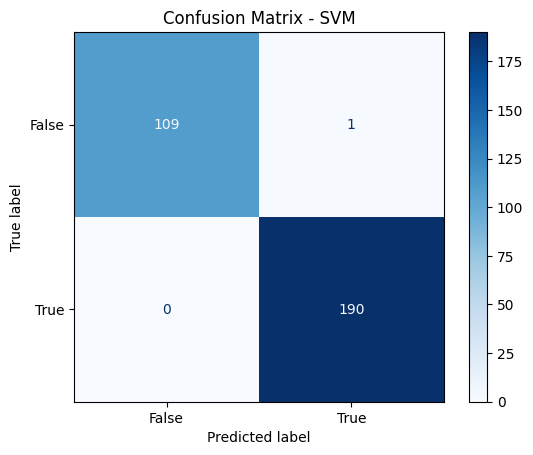

True positives (TP): 190
False negatives (FN): 0
False positive (FP): 1
True negatives (TN): 109
Accuracy: 0.9966666666666667
Precision: 0.9947643979057592
Recall: 1.0
F1 Score: 0.9973753280839895


In [ ]:
# SVM model
model_svm = SVC(random_state=42)
model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)

# Calculation of the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Display of confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                                  display_labels=model_svm.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM')
plt.show()

# Extracting values ​​from the confusion matrix
TP = cm_svm[1, 1] # True positive
TN = cm_svm[0, 0] # True negatives
FP = cm_svm[0, 1] # False positive
FN = cm_svm[1, 0] # False negatives

# Displaying metrics
print(f'True positives (TP): {TP}')
print(f'False negatives (FN): {FN}')
print(f'False positive (FP): {FP}')
print(f'True negatives (TN): {TN}')

# Calculation of other classification metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if\
 (precision + recall) > 0 else 0

# Display of other metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

* Very high accuracy of 0.9967, meaning 99.67% of the model's predictions are correct.

* Precision (0.9948): This means that of all the positive predictions from the model, 99.48% were actually correct. High accuracy indicates that the model makes very few false positive predictions (i.e. the model is very accurate when predicting a positive class).

* Recall (1.0): Recall of 1.0 (or 100%) indicates that the model correctly identified all positive instances without missing a single one. This means there were no false negatives.

* F1 Score (0.9974): The F1 Score is a harmonic average between precision and recall, and it is very high in this case, showing an excellent balance between these two metrics.

However, it is still important to check whether the data is balanced and whether these results hold up across different subsets of data or cross-validation, to ensure that there is no overfitting.

**Hyperparameter Optimization with GridSearchCV**

In [ ]:
# Define the parameters to test for the SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100], # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Kernel type
    'degree': [3, 4, 5], # Degree of the polynomial for the 'poly' kernel
}

# Initialize GridSearchCV with SVM model
grid_search_svm = GridSearchCV(SVC(random_state=42),
                               param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_scaled, y_train)

# Show the best parameters and cross-validation accuracy
print("Best parameters found: ", grid_search_svm.best_params_)
print("Best cross-validation accuracy: ", grid_search_svm.best_score_)

# Prediction and evaluation with the best SVM model
best_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_scaled)

print("Test accuracy: ", accuracy_score(y_test, y_pred_best_svm))

Best parameters found:  {'C': 1, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy:  0.9925
Test accuracy:  0.9933333333333333


The results show that the SVM model was well tuned and performed excellently on the validation and test data:

* Best Settings Found

C: 1
This indicates that the optimal regularization parameter is C=1. This setting balances model complexity and regularization well, helping to avoid overfitting while still being flexible enough to capture patterns in the data.

   degree: 3
This parameter is only relevant for the polynomial (poly) kernel, but in this case it is not really used because the optimal kernel found is linear.

   gamma:scale
For the linear kernel, gamma has no impact, but this shows that if another kernel had been selected, scale would have been the optimal choice.

   kernel: linear
The linear kernel turned out to be best for our problem, meaning the data is probably linearly separable, or close enough for this kernel to be effective.

* Model Performance

Best cross-validation accuracy: 0.9925
This means that in cross-validation on the training set, the SVM model achieved an average accuracy of 99.25%.

Test accuracy: 0.9933
On the test set, the model achieved 99.33% accuracy. This shows that the model generalizes well and that the performances observed in cross-validation translate well to unseen data.

**Cross validation**

In [ ]:
# Perform cross-validation for the SVM model
cross_val_scores_svm = cross_val_score(SVC(random_state=42),
                                       X_train_scaled, y_train, cv=5,
                                       scoring='accuracy')

# Show cross-validation scores for each fold
print("Cross-validation scores: ", cross_val_scores_svm)

# Calculate and display the average of cross-validation scores
print("Mean cross-validation score: ", cross_val_scores_svm.mean())

Cross-validation scores:  [0.99166667 0.99166667 0.9875     0.9875     0.99583333]
Mean cross-validation score:  0.9908333333333333


Model Stability: The cross-validation scores are very close to each other, suggesting that the SVM model is stable and is not overly sensitive to variations in the training data.

Overall performance: With an average of 99.08%, the model shows that it fits well on training data, and it is very likely that it behaves similarly on unseen data, as the accuracy also shows on the test set that we obtained previously.

**ROC curve**

An ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a binary classification model. It shows the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings.

In [ ]:
# SVM model with probability
model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_scaled, y_train)

# Probability prediction on test set
y_proba_svm = model_svm.predict_proba(X_test_scaled)[:, 1]

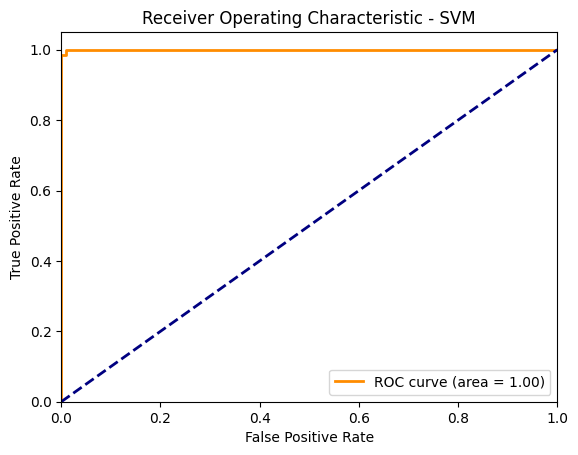

In [ ]:
# Calculation of ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svm)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.show()

The model is efficient since the curve is very close to (0, 1).

**Saving the model**

In [ ]:
# Save the trained Random Forest model
joblib.dump(best_svm, 'best_SVM_model.pkl')

['best_SVM_model.pkl']

In [ ]:
# Load saved model
loaded_model = joblib.load('best_SVM_model.pkl')

**Test the model**

In [ ]:
Test = pd.read_csv(
'/content/drive/MyDrive/projet 10 data analyse/billets_production.csv',
                    low_memory=False)

Test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
# Replace 'id' column with increasing numbers starting from 1
Test['id'] = range(1, len(Test) + 1)

# Show modified DataFrame
print(Test)

   diagonal  height_left  height_right  margin_low  margin_up  length  id
0    171.76       104.01        103.54        5.21       3.30  111.42   1
1    171.87       104.17        104.13        6.00       3.31  112.09   2
2    172.00       104.58        104.29        4.99       3.39  111.57   3
3    172.49       104.55        104.34        4.44       3.03  113.20   4
4    171.65       103.63        103.56        3.77       3.16  113.33   5


In [ ]:
# Drop id_column
Test = Test.drop(columns=['id'])

In [ ]:
# Standardize the data
scaler = StandardScaler()
Test_scaled = scaler.fit_transform(Test)

In [ ]:
Result = loaded_model.predict(Test_scaled)


Test['id'] = Result
Test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,False
1,171.87,104.17,104.13,6.00,3.31,112.09,False
2,172.00,104.58,104.29,4.99,3.39,111.57,False
3,172.49,104.55,104.34,4.44,3.03,113.20,True
4,171.65,103.63,103.56,3.77,3.16,113.33,True
